<h1>Detecting Emotion from Text</h1>

<p style="font-size: small">Ambrose Yip <br>Suryansh Saroch <br>Sami Khan <br>Arad Ayntabli <br>Daniel Folino  <p>

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import nltk
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from nltk.corpus import stopwords
import re
from collections import Counter
from tqdm.auto import tqdm

c:\Users\arada\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
warnings.filterwarnings("ignore")

In [4]:
nltk.download('punkt')          # For tokenization
nltk.download('stopwords')      # For stop words
nltk.download('wordnet')        # For lemmatizer
nltk.download('omw-1.4')        # For WordNet Lemmatizer's WordNet data
nltk.download('punkt_tab')      # Download data for multilingual sentence tokenization

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arada\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arada\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arada\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\arada\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\arada\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
data = pd.read_csv('text.csv')

# Check for NaN values in the target column
if 'label' not in data.columns:
    print("Column 'label' not found. Here are the columns:", data.columns)
else:
    if data['label'].isna().sum() > 0:
        print("Found NaN in target variable, handling them...")
        data = data.dropna(subset=['label'])

data

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...,...
416804,416804,i feel like telling these horny devils to find...,2
416805,416805,i began to realize that when i was feeling agi...,3
416806,416806,i feel very curious be why previous early dawn...,5
416807,416807,i feel that becuase of the tyranical nature of...,3


<h2>Preprocessing the data</h2>

In [7]:
def clean_text(s: str) -> str:
    s = re.sub(r"[^\w\s]", '', s)  # Remove all non-word characters
    s = re.sub(r"\s+", '', s)       # Remove multiple whitespaces
    s = re.sub(r"\d", '', s)        # Remove digits
    return s


In [8]:
def build_vocabulary(sentences) -> dict:
    word_list = []
    stop_words = set(stopwords.words('english'))
    for sentence in sentences:
        for word in sentence.lower().split():
            processed_word = clean_text(word)
            if processed_word not in stop_words and processed_word != '':
                word_list.append(processed_word)
    corpus = Counter(word_list)
    most_common_words = sorted(corpus, key=corpus.get, reverse=True)[:1000]
    vocab = {w: i+1 for i, w in enumerate(most_common_words)}
    return vocab

In [9]:
def preprocess_data(df: pd.DataFrame):
    X, y = df['text'].values, df['label'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
    vocab = build_vocabulary(X_train)

    def text_to_indices(text_array, vocab_dict):
        new_text = []
        for sentence in text_array:
            indexed_sentence = [vocab_dict[clean_text(word)] for word in sentence.lower().split() if clean_text(word) in vocab_dict]
            new_text.append(indexed_sentence)
        return new_text

    X_train = text_to_indices(X_train, vocab)
    X_test = text_to_indices(X_test, vocab)

    return X_train, X_test, y_train, y_test, vocab

In [10]:
X_train, X_test, y_train, y_test, vocab = preprocess_data(data)

In [11]:
# Padding Sequences
def pad_sequences(sequences, seq_len: int):
    features = np.zeros((len(sequences), seq_len), dtype=int)
    for i, review in enumerate(sequences):
        if len(review) != 0:
            features[i, -len(review):] = np.array(review)[:seq_len]
    return features

In [12]:
max_seq_length = 30
X_train = pad_sequences(X_train, max_seq_length)
X_test = pad_sequences(X_test, max_seq_length)

In [13]:
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)
X_test, y_test = torch.Tensor(X_test), torch.LongTensor(y_test)

In [14]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: torch.Size([333447, 30])
y_train: torch.Size([333447])
X_test: torch.Size([83362, 30])
y_test: torch.Size([83362])


In [15]:
# Create Datasets and Dataloaders
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

<h2>The Model</h2>

In [16]:
# Model
class EmotionClassifier(nn.Module):
    def __init__(self, num_layers, vocab_size, hidden_dim, embedding_dim, output_dim, dropout_prob=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn1 = nn.BatchNorm1d(hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 4)
        self.output = nn.Linear(hidden_dim // 4, output_dim)

    def forward(self, x, hidden):
        x = self.embedding(x)
        x, hidden = self.lstm(x, hidden)
        x = x[:, -1, :]  # Last time step
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = F.dropout(x, p=0.5, training=self.training)
        return self.output(x), hidden

    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.num_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.num_layers, batch_size, self.hidden_dim)).to(device)
        return (h0, c0)

In [17]:
def create_model():
    model = EmotionClassifier(
        num_layers=2,
        vocab_size=len(vocab) + 1,
        hidden_dim=128,
        embedding_dim=64,
        output_dim=6,
        dropout_prob=0.5
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model, criterion, optimizer


<h2>Training</h2>

In [18]:
# Training Function
###################################
def train_model(epochs):
    model, criterion, optimizer = create_model()
    model.to(device)

    clip = 5
    train_acc_history, train_loss_history = [], []
    test_acc_history, test_loss_history = [], []
    y_true_all, y_pred_all = [], []

    for epoch in tqdm(range(epochs), desc="Training Progress"):
        # Training
        model.train()
        hidden = model.init_hidden(batch_size)
        batch_accuracies, batch_losses = [], []
        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device, dtype=torch.int64), y_batch.to(device)
            hidden = tuple([each.data for each in hidden])
            y_hat, hidden = model(X_batch, hidden)
            loss = criterion(y_hat, y_batch)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            preds = torch.argmax(y_hat.detach().cpu(), axis=1)
            acc = (preds == y_batch.cpu()).float().mean() * 100
            batch_accuracies.append(acc.item())
            batch_losses.append(loss.item())

        train_acc = np.mean(batch_accuracies)
        train_loss = np.mean(batch_losses)
        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss)

        # Validation
        model.eval()
        hidden = model.init_hidden(batch_size)
        batch_accuracies, batch_losses = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_dataloader:
                X_batch, y_batch = X_batch.to(device, dtype=torch.int64), y_batch.to(device)
                hidden = tuple([each.data for each in hidden])
                y_hat, hidden = model(X_batch, hidden)
                loss = criterion(y_hat, y_batch)

                preds = torch.argmax(y_hat.cpu(), axis=1)
                acc = (preds == y_batch.cpu()).float().mean() * 100
                batch_accuracies.append(acc.item())
                batch_losses.append(loss.item())

                y_true_all.extend(y_batch.cpu().tolist())
                y_pred_all.extend(preds.tolist())

        test_acc = np.mean(batch_accuracies)
        test_loss = np.mean(batch_losses)
        test_acc_history.append(test_acc)
        test_loss_history.append(test_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.2f}% | Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.2f}% | Test Loss: {test_loss:.4f}")

    return model, train_acc_history, test_acc_history, train_loss_history, test_loss_history, y_true_all, y_pred_all

In [19]:
# Train the Model
epochs = 20
model, train_acc, test_acc, train_loss, test_loss, y_true, y_pred = train_model(epochs)

Training Progress:   5%|▌         | 1/20 [02:29<47:15, 149.24s/it]

Epoch 1/20 | Train Acc: 46.34% | Train Loss: 1.3911 | Test Acc: 75.15% | Test Loss: 0.7256


Training Progress:  10%|█         | 2/20 [04:47<42:51, 142.83s/it]

Epoch 2/20 | Train Acc: 79.77% | Train Loss: 0.6200 | Test Acc: 87.00% | Test Loss: 0.3739


Training Progress:  15%|█▌        | 3/20 [07:09<40:21, 142.43s/it]

Epoch 3/20 | Train Acc: 86.07% | Train Loss: 0.4443 | Test Acc: 87.92% | Test Loss: 0.3223


Training Progress:  20%|██        | 4/20 [09:24<37:14, 139.63s/it]

Epoch 4/20 | Train Acc: 87.68% | Train Loss: 0.3838 | Test Acc: 88.97% | Test Loss: 0.2821


Training Progress:  25%|██▌       | 5/20 [11:38<34:21, 137.43s/it]

Epoch 5/20 | Train Acc: 88.29% | Train Loss: 0.3524 | Test Acc: 89.10% | Test Loss: 0.2621


Training Progress:  30%|███       | 6/20 [13:53<31:54, 136.77s/it]

Epoch 6/20 | Train Acc: 88.60% | Train Loss: 0.3307 | Test Acc: 89.09% | Test Loss: 0.2535


Training Progress:  35%|███▌      | 7/20 [16:10<29:37, 136.73s/it]

Epoch 7/20 | Train Acc: 88.85% | Train Loss: 0.3168 | Test Acc: 89.20% | Test Loss: 0.2472


Training Progress:  40%|████      | 8/20 [18:25<27:12, 136.01s/it]

Epoch 8/20 | Train Acc: 89.10% | Train Loss: 0.3035 | Test Acc: 89.06% | Test Loss: 0.2418


Training Progress:  45%|████▌     | 9/20 [20:41<24:57, 136.09s/it]

Epoch 9/20 | Train Acc: 89.18% | Train Loss: 0.2954 | Test Acc: 89.12% | Test Loss: 0.2397


Training Progress:  50%|█████     | 10/20 [23:03<22:59, 137.94s/it]

Epoch 10/20 | Train Acc: 89.27% | Train Loss: 0.2898 | Test Acc: 89.33% | Test Loss: 0.2375


Training Progress:  55%|█████▌    | 11/20 [25:27<20:58, 139.80s/it]

Epoch 11/20 | Train Acc: 89.33% | Train Loss: 0.2847 | Test Acc: 89.47% | Test Loss: 0.2384


Training Progress:  60%|██████    | 12/20 [27:54<18:57, 142.16s/it]

Epoch 12/20 | Train Acc: 89.36% | Train Loss: 0.2812 | Test Acc: 89.41% | Test Loss: 0.2329


Training Progress:  65%|██████▌   | 13/20 [30:27<16:56, 145.23s/it]

Epoch 13/20 | Train Acc: 89.48% | Train Loss: 0.2765 | Test Acc: 89.36% | Test Loss: 0.2342


Training Progress:  70%|███████   | 14/20 [32:56<14:38, 146.40s/it]

Epoch 14/20 | Train Acc: 89.55% | Train Loss: 0.2736 | Test Acc: 89.47% | Test Loss: 0.2337


Training Progress:  75%|███████▌  | 15/20 [35:24<12:14, 146.85s/it]

Epoch 15/20 | Train Acc: 89.70% | Train Loss: 0.2700 | Test Acc: 89.26% | Test Loss: 0.2336


Training Progress:  80%|████████  | 16/20 [37:49<09:45, 146.44s/it]

Epoch 16/20 | Train Acc: 89.74% | Train Loss: 0.2657 | Test Acc: 89.12% | Test Loss: 0.2334


Training Progress:  85%|████████▌ | 17/20 [40:13<07:16, 145.51s/it]

Epoch 17/20 | Train Acc: 89.80% | Train Loss: 0.2640 | Test Acc: 89.39% | Test Loss: 0.2331


Training Progress:  90%|█████████ | 18/20 [42:30<04:46, 143.01s/it]

Epoch 18/20 | Train Acc: 89.85% | Train Loss: 0.2603 | Test Acc: 89.30% | Test Loss: 0.2362


Training Progress:  95%|█████████▌| 19/20 [44:40<02:19, 139.05s/it]

Epoch 19/20 | Train Acc: 89.93% | Train Loss: 0.2578 | Test Acc: 89.13% | Test Loss: 0.2367


Training Progress: 100%|██████████| 20/20 [46:51<00:00, 140.57s/it]

Epoch 20/20 | Train Acc: 89.97% | Train Loss: 0.2551 | Test Acc: 89.18% | Test Loss: 0.2389


<h2>Results</h2>

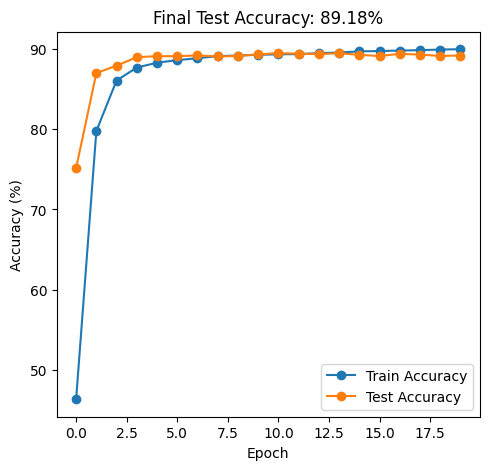

In [20]:
# Accuracy Curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_acc, 'o-', label='Train Accuracy')
plt.plot(test_acc, 'o-', label='Test Accuracy')
plt.title(f'Final Test Accuracy: {test_acc[-1]:.2f}%')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()


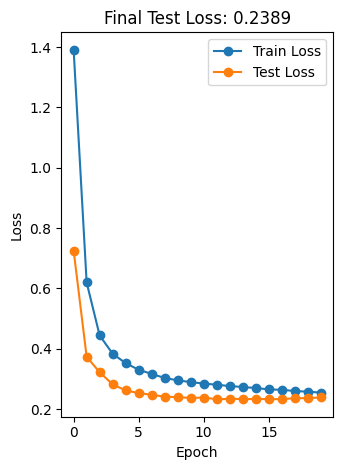

In [21]:
# Loss Curves
plt.subplot(1,2,2)
plt.plot(train_loss, 'o-', label='Train Loss')
plt.plot(test_loss, 'o-', label='Test Loss')
plt.title(f'Final Test Loss: {test_loss[-1]:.4f}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


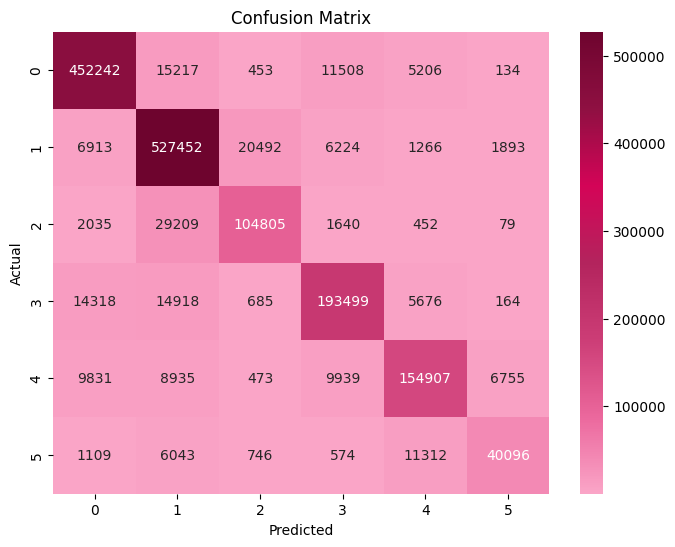

In [22]:
# Confusion Matrix

cm = confusion_matrix(y_true, y_pred)
color_list = ['#faa5c7', '#eb679c', '#cc3d76', '#b3245d', '#d40457', '#8f1042', '#6e042e']
cmap = LinearSegmentedColormap.from_list('custom_palette', color_list, N=256)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap=cmap, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# Performance Metrics
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')
f1 = f1_score(y_true, y_pred, average='micro')

print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {f1:.4f}")

Precision: 0.8835 | Recall: 0.8835 | F1-Score: 0.8835


<h2>Demo Run</h2>

In [24]:
def predict_emotion(sentence, vocab, model, max_seq_length):
    #preprocess the sentence
    emotion = {0:'Sadness',1:'Joy',2:'love',3:'anger',4:'fear',5:'surprise'}
    words = [clean_text(word) for word in sentence.lower().split()]
    indices = [vocab[word] for word in words if word in vocab]
    
    padded_sequence = pad_sequences([indices], max_seq_length)
    #convert it to a tensor
    input_tensor = torch.Tensor(padded_sequence).to(device, dtype=torch.int64)
    #make the prediction
    model.eval()
    hidden = model.init_hidden(1)
    with torch.no_grad():
        output,_ = model(input_tensor,hidden)
        prediction = torch.argmax(output, axis=1).item()
    return emotion[prediction]

In [25]:
prediction = predict_emotion("I'm scared of chocolate", vocab, model, max_seq_length)
print(f"The predicted emotion is {prediction}\n")


The predicted emotion is fear



In [26]:
prediction = predict_emotion("I am so happy I took machine learning", vocab, model, max_seq_length)
print(f"The predicted emotion is {prediction}\n")

The predicted emotion is Joy

